In [1]:
import pymysql
from sqlalchemy import create_engine 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import time

In [2]:
class TeamColor():
    def __init__(self):
        self.pkl = pd.read_pickle('pickles/owl_colors.pickle')

    def get_hex_color(self, team_full_name):
        '''
        parameters: str, team_full_name, (enter team's full name)
        '''
        for team in self.pkl.keys():
            fullName = self.pkl[team]['fullName']
            if fullName == team_full_name:
                mainColor = self.pkl[team]['secondaryColor']
                color_in_hex = self.pkl[team]['colors'][mainColor]['hex']
                pass
            else:
                pass
        return color_in_hex
    
    def get_rgb_color(self, team_full_name):
        '''
        parameters: team_full_name, (enter team's full name)
        '''
        for team in self.pkl.keys():
            fullName = self.pkl[team]['fullName']
            if fullName == team_full_name:
                mainColor = self.pkl[team]['secondaryColor']
                color_in_rgb = self.pkl[team]['colors'][mainColor]['rgb']
                pass
            else:
                pass
        return color_in_rgb

In [3]:
teamcolor = TeamColor().get_hex_color('New York Excelsior')
print(teamcolor)

#0F57EA


In [4]:
class TeamNameConverter():
    def __init__(self):
        self.pkl = pd.read_pickle('pickles/df_esports_team_id.pickle')
    
    def to_id(self, team_full_name):
        '''
        parameters: str, team_full_name (enter team's full name)
        '''
        team_id = int(self.pkl[self.pkl['team_name'] == team_full_name]['team_id'])

        return team_id

    def to_name(self, team_id):
        '''
        parameters: int, team_id (enter team's id)
        '''
        team_name = (self.pkl[self.pkl['team_id'] == team_id]['team_name']).values[0]

        return team_name

In [5]:
team_id = TeamNameConverter().to_id('New York Excelsior')
team_name = TeamNameConverter().to_name(4403)
print(team_id)
print(team_name)

4403
New York Excelsior


In [6]:
def get_ts_map_start_end(match_id=None): # get map start and end times from pickle
    '''
    parameters: match_id: int

    returns:    ts_match_start, ts_map_start, ts_map_end (int, pandas.Series, pandas.Series)
    '''
    # get map start and end time
    path = 'D:\owl-data\pickles'
    file_name = 'OWL_map_start_info'
    timestamps = pd.read_pickle(os.path.join(path, file_name))

    # send error msg if there is no match_id
    if timestamps['esports_match_id'].isin([match_id]).any() == False:
        raise ValueError('there is no match_id in OWL_map_start_info')

    timestamps = timestamps[timestamps['esports_match_id'] == match_id]
    timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
    ts_match_start = timestamps['time_gamestart'].min()

    ts_map_start = timestamps['time_gamestart']
    ts_map_start.reset_index(drop=True, inplace=True)
    ts_map_end = timestamps['time_gameresult']
    ts_map_end.reset_index(drop=True, inplace=True)
    
    return ts_match_start, ts_map_start, ts_map_end

In [7]:
def get_team_info(match_id=None):
    '''
    parameters: match_id: int

    returns:    team_one_name, team_one_id, team_two_name, team_two_id (str, int, str, int)
    '''
    # get team_names
    path = 'D:\owl-data'
    file_name = 'OWL_match_results.csv'
    match_results = pd.read_csv(os.path.join(path, file_name))
    match_results = match_results[match_results['esports_match_id'] == match_id][['team_one_name', 'team_two_name']]
    match_results.reset_index(inplace=True)
    team_one_name = match_results.loc[0, 'team_one_name']
    team_two_name = match_results.loc[0, 'team_two_name']
    
    # get team_ids
    esports_team_id = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'df_esports_team_id.pickle'))
    team_one_id = int(esports_team_id[esports_team_id['team_name'] == team_one_name]['team_id'])
    team_two_id = int(esports_team_id[esports_team_id['team_name'] == team_two_name]['team_id'])

    return team_one_name, team_one_id, team_two_name, team_two_id

In [8]:
def get_map_info(match_id=None):
    '''
    parameters: match_id: int

    returns:    map names (series)
    '''
    # get team_names
    path = 'D:\owl-data'
    file_name = 'OWL_match_results.csv'
    match_results = pd.read_csv(os.path.join(path, file_name))
    match_results = match_results[match_results['esports_match_id'] == match_id][['map_name']]
    match_results.reset_index(inplace=True)
    map_names = match_results['map_name']
    
    return map_names

In [9]:
# Get event timestamps
def getEvents(match_id=None, ssg=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # send query
    table_id = f'match_{match_id}'

    if team_id == 0: # default
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' ORDER BY `time`;"
    else: # where designated team_id
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' AND `esports_team_id` = '{team_id}' ORDER BY `time`;"

    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time in ms
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)

    # get map start times and end times
    map_start_times = ts_map_start - ts_match_start # set match start time as 0
    map_end_times = ts_map_end - ts_match_start # set match start time as 0

    # groupby df
    df2 = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    df2['time'] = pd.to_numeric(df2['time'])
    df2['time'] = df2['time'] / 1000 # ms to s
    df2['time'] = df2['time'] - ts_match_start # set match start time as 0

    sum_df = df2.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps
    
    sum_df = sum_df.droplevel(level='short_stat_guid')
    sum_df = sum_df.reset_index(level='time')
    sum_df['dx'] = sum_df['amount'].diff()
    sum_df['dt'] = sum_df['time'].diff()
    sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
    
    # define event time with threshold
    sum_df['event'] = sum_df['dx'] > threshold # True if dx > threshold
    
    # transform time (int) into UTC datetime
    sum_df['time'] += ts_match_start
    sum_df['time'] = pd.to_datetime(sum_df['time'], unit='s', utc=True)
    
    # resample
    # sum_df = sum_df.resample(interval, on='time').sum()

    return sum_df

In [10]:
def getEvents_alives(match_id=None, team_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    dataframe, (pandas.DataFrame[['time', 'amount']])
    '''
    def import_esd(match_id=match_id, dbname="esd_phs", stat_lifespan='GAME', stat_category='Hero', **kwargs):
        '''
        parameters: match_id
                    kwargs: ['index', 'time', 'hero_guid', 'stat_lifespan', 'hero_name', 'short_stat_guid', 'amount', 'stat_name', 'stat_category', 'battletag', 'esports_player_id', 'esports_team_id']
        
        returns:    pd.DataFrame from MySQL DB
        '''
        # get sql from parameters
        table_id = f'match_{match_id}'
        sql = f"SELECT * FROM `{table_id}` WHERE `stat_lifespan` = '{stat_lifespan}' AND `stat_category` = '{stat_category}'"
        
        if len(kwargs) != 0:
            for name, value in kwargs.items():
                sql = sql + f" AND `{name}` = '{value}'"
        sql = sql + " ORDER BY `time`;"
        print(sql)

        # Credentials to DB connection
        hostname = "localhost" 
        username = "root"
        pwd = "gpdlzjadh"
        dbname = dbname #"esd_phs"
        charset = "utf8"

        # Create connection to MySQL DB
        conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
        cur = conn.cursor()

        # send query
        df = pd.read_sql(sql, conn)

        cur.close()
        conn.close()

        # preprocess dataframe
        # convert `time` column type from str to datetime
        df['time'] = df['time'].astype(float)
        df['time'] = df['time'] / 1000 # ms to s
        df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
        
        df['battletag'] = df['battletag'].str.split('#').str[0] # drop str after '#' in `battletag`
        df.drop(['index'], axis=1, inplace=True)
        df.set_index('time', inplace=True) # set 'time' column as index

        # slice only map played timeline
        # get map start and end time in ms
        ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)
        esd_tf = pd.DataFrame()
        for idx in ts_map_start.index:
            start, end = to_datetime(ts_map_start.loc[idx]), to_datetime(ts_map_end.loc[idx])
            df_tmp = df[start:end]
            df_tmp['map_order'] = idx + 1
            
            esd_tf = pd.concat([esd_tf, df_tmp], ignore_index=False) # index:datetime
        
        return esd_tf

    ###
    # get 1137 (time alive, no match)
    time_alive = import_esd(match_id=match_id, short_stat_guid=1137, esports_team_id=team_id) # 1133: each hero, 1137: no match
    grouping = ['time', 'battletag', 'hero_name']
    time_alive = time_alive.groupby(by=grouping).max()['amount']
    
    # diff()
    dx = time_alive.groupby(level=[x for x in list(time_alive.index.names) if x != 'time']).diff().fillna(time_alive) # fill nan as first value

    # define alive (time alive > 0) and not alive (time alive == 0)
    events_alives = dx>0

    # sum player's amount
    events_alives = events_alives.groupby(by='time').sum()

    # transform to [['time', 'amount']]
    events_alives = events_alives.reset_index()
    events_alives = events_alives[['time', 'amount']]

    return events_alives

In [11]:
def getEvents_RCP(match_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}

    returns:    events_RCP (pandas.DataFrame[['time', 'amount_{team_one}', 'amount_{team_two}', 'RCP']])

    reference:  https://youtu.be/wpjxWBwLkIE
    '''
    # get team info
    team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=match_id)

    team_one_alives = getEvents_alives(match_id=match_id, team_id=team_one_id)
    team_one_alives.rename(columns={'amount':'Alives'}, inplace=True)
    team_two_alives = getEvents_alives(match_id=match_id, team_id=team_two_id)
    team_two_alives.rename(columns={'amount':'Alives'}, inplace=True)
    events_RCP = team_one_alives.merge(team_two_alives, how='outer', on='time', suffixes=(f'_{team_one_name}', f'_{team_two_name}'))
    # events_RCP['RCP'] = (events_RCP[f'Alives_{team_one_name}'] * events_RCP[f'Alives_{team_one_name}']) - (events_RCP[f'Alives_{team_two_name}'] * events_RCP[f'Alives_{team_two_name}'])
    events_RCP['RCP'] = (events_RCP[f'Alives_{team_one_name}']**2) - (events_RCP[f'Alives_{team_two_name}']**2)
    events_RCP['RCP'] = events_RCP['RCP'] / (events_RCP[[f'Alives_{team_one_name}', f'Alives_{team_two_name}']].max(axis=1)) # 란체스터 법칙 in small group 사용: Af = (A0^2 - B0^2) / A0

    return events_RCP

In [12]:
def getEvents_finalblows(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 44

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [13]:
def getEvents_herodamagedone(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=400):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 400 (float)

    returns:    event_alldamagedone (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 1208 # Hero_Damage_Done

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [14]:
def to_datetime(time):
    '''
    parameters: time: UTC timestamp in second(int)

    returns:    pd. datetime in seconds, UTC
    '''
    t = pd.to_datetime(time, unit='s', utc=True)

    return t

In [15]:
# TF detector
def TF_detector(df_rolling):
    '''
    parameters: dataframe
    <시작 조건>
    시작 조건 0. TF 중 = False
    시작 조건 1. time > 이전 TF 종료 시간
    시작 조건 2. HDD >= {HDD_threshold=500} (time - )
    시작 조건 3. FB > 0, time - {possible_time_variance=1}
    시작 조건 4. HDD >= {HDD_threshold=500} 시간 이후, first FB=False 상태로 HDD < {HDD_lull_cut=50} 생기면 이전 HDD time 제외

    <종료 조건>
    종료 조건 0. TF 진행 중 = True
    종료 조건 1. FB = 0 이 {no_FB_duration=10}초 이상
    종료 조건 2. time = ts_map_end_time

    *stagger
    *길어지는 한타
    FB 0 되고 10s동안 추가 킬이 없어야 한타 종료로 인정

    return:     TF_timestamps: dataframe of [['match_id', 'map_num', 'TF_start_time_stamps', 'TF_end_time_stamps']]
    '''
    global is_TF_ongoing
    is_TF_ongoing = False
    global FB_happened
    FB_happened = False
    global FB_silence
    FB_silence = False

    TF_start_time_stamps = []
    TF_end_time_stamps = []

    HDD_threshold = 500
    HDD_lull_cut = 500
    FB_threshold = 0
    possible_time_variance = 2
    no_FB_duration = 10

    # start condition
    def TF_start(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence
        
        def condition0(): # TF 중 = False
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = False
            else:
                cond0 = True
            return cond0

        def condition1(idx): # time > 이전 TF 종료 시간
            if (idx < df_rolling.index[-1]) == True:
                cond1 = True
            else:
                cond1 = False
            return cond1

        def condition2(idx): # HDD >= {HDD_threshold}
            if df_rolling.loc[idx, 'HDD'] > HDD_threshold:
                cond2 = True
            else:
                cond2 = False
            return cond2 
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # HDD가 오르는 추세에 있어야
            if (df_rolling.loc[idx - pd.to_timedelta(no_FB_duration, unit='s') : idx, 'HDD'].mean() <= df_rolling.loc[idx : idx + pd.to_timedelta(no_FB_duration, unit='s'), 'HDD'].mean()) == True:
                cond4 = True
            else:
                cond4 = False
            return cond4 
        
        def condition5(idx): # HDD 가 {no_FB_duration} 범위에서 최소값일 경우
            if (df_rolling.loc[idx, 'HDD'] <= df_rolling.loc[idx : idx + pd.to_timedelta(no_FB_duration, unit='s'), 'HDD'].min()) == True:
                cond5 = True
            else:
                cond5 = False
            return cond5 


        # check if start_condition == True
        start_condition = condition0() & condition1(idx) & ( (condition2(idx) & condition4(idx) & condition5(idx)) | condition3(idx) ) 
        
        if start_condition == True:
            is_TF_ongoing = True # toggle on
            FB_silence = False # toggle off

        return is_TF_ongoing
    
    # end condition
    def TF_end(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence

        def condition0(): # TF 진행 중 = True
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = True
            else:
                cond0 = False 
            return cond0

        def condition1(idx): # FB = 0 이 {no_FB_duration}초 이상 유지될 때
            global FB_silence
            if df_rolling.loc[idx: idx + pd.to_timedelta(no_FB_duration, unit='s'), 'FB'].sum() == 0:
                cond1 = True 
                FB_silence = True # toggle on
            else:
                cond1 = False
            return cond1 
        
        def condition2(idx): # time = ts_map_end_time (Map이 종료됐을 때)
            if idx == df_rolling.index[-1]:
                cond2 = True
            else:
                cond2 = False
            return cond2
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # while FB == 0 & HDD <= {HDD_lull_cut}
            if (df_rolling.loc[idx, 'FB'] == 0) & (df_rolling.loc[idx, 'HDD'] <= HDD_lull_cut):
                cond4 = True
            else:
                cond4 = False
            return cond4
        
        def condition5(idx): # 2s 동안 mean(HDD) < HDD_threshold 
            if df_rolling.loc[idx:idx + pd.to_timedelta(2, unit='s'), 'HDD'].mean() < HDD_threshold:
                cond5 = True
            else:
                cond5 = False
            return cond5

        # init FB_happened
        condition3(idx)

        # check if end_condition == True
        end_condition = ( condition0() & ((condition1(idx) & condition5(idx)) & FB_happened) | (FB_happened & condition4(idx)) ) | condition2(idx)

        if end_condition == True:
            is_TF_ongoing = False # toggle off
            FB_happened = False # toggle off

        return is_TF_ongoing

    TF_status = []

    for idx in df_rolling.index:
        if is_TF_ongoing == False:
            TF_status.append(TF_start(idx))
        else:
            TF_status.append(TF_end(idx))

    df_rolling['TF_status'] = TF_status

    return df_rolling # [['RCP', 'HDD', 'FB', 'TF_status']], index=UTC timestamp

In [16]:
# get TF_time_range
def get_true_range(df=None, column='TF_status'):
    '''
    parameters: data: dataframe with timestamp index
                column: target column to arrange
    
    returns:    index tuple
    '''
    range_list = []
    prev_val = False

    for inx, val in df[column].iteritems():
        if prev_val != val:
            if val:
                start = inx
            else:
                range_list.append((start, inx))

        prev_inx = inx
        prev_val = val
    
    return range_list

In [17]:
def get_esports_match_ids(team_name='All', opponent_name='All', winner='All', loser='All', season='All', map_name='All'):
    '''
    parameters: team_name: target team name
                opponent_name: opponent team name
                winner: winner team name
                loser: loser team name
                season: 2018, 2019, 2020
                map: map name
                period: datetime range e.g.('2020-08-01':'2020-09-01')
    
    returns:    esports_match_ids
    '''
    df = pd.read_csv(os.path.join('D:\owl-data', 'OWL_match_results.csv'))

    # df1 (search team_name)
    if team_name == 'All':
        df1 = df
    else:
        df1 = pd.concat([df[df['team_one_name'].str.contains(team_name)], df[df['team_two_name'].str.contains(team_name)]])
    
    # df2 (search opponent_name)
    if opponent_name == 'All':
        df2 = df1
    else:
        df2 = pd.concat([df1[df1['team_one_name'].str.contains(opponent_name)], df1[df1['team_two_name'].str.contains(opponent_name)]]) 
    
    # df3 (search winner)
    if winner == 'All':
        df3 = df2
    else:
        df3 = df2[df2['match_winner'] == winner]
    
    # df4 (search loser): loser 검색 시에는 반드시 team_name or opponent_name 설정을 해줘야 함
    if loser == 'All':
        df4 = df3
    else:
        if team_name == 'All' & opponent_name == 'All':
            raise ValueError('define team_name or opponent_name first')
        else:
            df4 = df3[df3['match_winner'] != loser]
    
    # df5 (search season)
    if season == 'All':
        df5 = df4
    else:
        season_id = str(season - 2017) # 2018 = 1st season
        df5 = df4[df4['esports_match_id'].astype(str).str.startswith(season_id)]

    # df6 (search map_name)
    if map_name == 'All':
        df6 = df5
    else:
        df6 = df5[df5['map_name'].str.contains(map_name)]

    esports_match_ids = df6['esports_match_id'].unique()

    return esports_match_ids

## Get Teamfight timestamps and info

In [18]:
def get_teamfight_info(match_id=None, plotting=False, **kwargs):
    '''
    parameters:     match_id
                    plotting: plot graphs if True
                    *kwargs: item=['HDD', 'FB', 'RCP'] (maximum 2 of 3 items to plot. ex. ['HDD', 'FB'])

    returns:        dataframe of teamfight info
    '''
    # HDB, FB, RCP
    stat_lifespan = 'GAME'
    events_finalblows = getEvents_finalblows(match_id=match_id, stat_lifespan=stat_lifespan)
    events_herodamagedone = getEvents_herodamagedone(match_id=match_id, stat_lifespan=stat_lifespan)
    events_RCP = getEvents_RCP(match_id=match_id, stat_lifespan=stat_lifespan)

    # put all relevant stats into df_TF
    # RCP
    df1 = events_RCP[['time', 'RCP']]
    # HDD
    df2 = events_herodamagedone[['time', 'dx']]
    df2 = df2.rename(columns={'dx':'HDD'})
    # FB
    df3 = events_finalblows[['time', 'dx']]
    df3 = df3.rename(columns={'dx':'FB'})
    # merge
    df_TF = df1.merge(df2, how='outer', on='time')
    df_TF = df_TF.merge(df3, how='outer', on='time')
    # remove (-) values in HDD/s and FB (it appears when a map starts cuz 'dx' was calculated by diff())
    df_TF = df_TF[df_TF['HDD'] >= 0]
    df_TF = df_TF[df_TF['FB'] >= 0]

    # resampling to align timeline
    resample = df_TF.resample('2s', on='time').sum()

    # get df of rolling with moving window
    window = 5 # indicates 10 sec (window * 2 sec (Blizzard provides 2sec ESD sampling frequency))
    rolling = resample.rolling(window=window, center=True, min_periods=1).sum() # sum rolling windows with min_periods=1

    # get map info
    map_names = get_map_info(match_id=match_id)

    # get team info
    team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=match_id)
    
    # match start timestamps
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)
    ts_match_start = pd.to_datetime(ts_match_start, unit='s', utc=True)

    # get df of teamfight info
    df_TF_match = pd.DataFrame()

    for m in map_names.index:
        df_map = rolling[to_datetime(ts_map_start[m]): to_datetime(ts_map_end[m])]
        df_map = TF_detector(df_map)
        TF_time_range = get_true_range(df_map)


        # get teamfight info by maps
        df_TF_map = pd.DataFrame(TF_time_range, columns=['TF_start_datetime', 'TF_end_datetime'])
        df_TF_map['esports_match_id'] = match_id
        df_TF_map['map_name'] = map_names[m]
        df_TF_map['map_order'] = m + 1
        
        # define TF winner and RCP
        TF_winner_list = []
        TF_order_list = []
        TF_duration_list = []
        TF_RCP_list = []
        TF_RCPps_list = [] # RCP/s
        TF_order = 0
        
        for idx in df_TF_map.index:
            TF_order += 1
            TF_order_list.append(TF_order)
            TF_duration_list.append((df_TF_map.loc[idx, 'TF_end_datetime'] - df_TF_map.loc[idx, 'TF_start_datetime']).seconds) # TF duration in s
            TF_RCP_sum = df_map.loc[df_TF_map.loc[idx, 'TF_start_datetime']:df_TF_map.loc[idx, 'TF_end_datetime'], 'RCP'].sum()
            TF_RCP_list.append(TF_RCP_sum) # RCP
            TF_RCPps_list.append(TF_RCP_sum / ((df_TF_map.loc[idx, 'TF_end_datetime'] - df_TF_map.loc[idx, 'TF_start_datetime']).seconds)) # RCP / s
            if TF_RCP_sum > 0:
                TF_winner_list.append(team_one_name)
            elif TF_RCP_sum == 0:
                TF_winner_list.append('draw')
            else:
                TF_winner_list.append(team_two_name)
        df_TF_map['TF_order'] = TF_order_list
        df_TF_map['TF_winner'] = TF_winner_list
        df_TF_map['TF_duration'] = TF_duration_list
        df_TF_map['TF_RCP_sum'] = TF_RCP_list
        df_TF_map['TF_RCP_sum/s'] = TF_RCPps_list

        # plot if plotting == True
        fig_opt={'figsize':(20,10), 'linewidth':1, 'color_TF_shading':'gray', 'color_HDD':'green', 'color_FB':'red', 'color_RCP':'black'}
        if plotting == True:
            figsize = fig_opt['figsize']
            linewidth = fig_opt['linewidth']
            color_TF_shading = fig_opt['color_TF_shading']
            color_HDD = fig_opt['color_HDD']
            color_FB = fig_opt['color_FB']
            color_RCP = fig_opt['color_RCP']

            plt.figure(figsize=figsize)

            plt.title(f'{match_id}_{team_one_name} vs {team_two_name} in {map_names[m]}')

            pitem = kwargs['item'] # get plotting items
            if len(pitem) == 1: # only one item
                # set line color
                if 'HDD' in pitem == True:
                    color = color_HDD
                elif 'FB' in pitem == True:
                    color = color_FB 
                elif 'RCP' in pitem == True:
                    color = color_RCP 
                
                sns.lineplot(x='time', y=pitem, data=df_map, color=color, linewidth=linewidth)  
                plt.ylabel(pitem)
            
            elif len(pitem) > 1:
                # set line color
                if pitem[0] == 'HDD':
                    color0 = color_HDD
                elif pitem[0] == 'FB':
                    color0 = color_FB 
                elif pitem[0] == 'RCP':
                    color0 = color_RCP 

                if pitem[1] == 'HDD':
                    color1 = color_HDD
                elif pitem[1] == 'FB':
                    color1 = color_FB 
                elif pitem[1] == 'RCP':
                    color1 = color_RCP 

                ax = sns.lineplot(x='time', y=pitem[0], data=df_map, color=color0, linewidth=linewidth)
                plt.ylabel(pitem[0])
                ax1 = ax.twinx()
                sns.lineplot(x='time', y=pitem[1], data=df_map, color=color1, ax=ax1, linewidth=linewidth)
                plt.ylabel(pitem[1])
            
            elif len(pitem) > 2:
                raise ('Too many items to plot')

            
            # plot shading during teamfight
            for (start, end) in TF_time_range:
                plt.axvspan(start, end, color=color_TF_shading, alpha=0.5)

            plt.xlim(to_datetime(ts_map_start[m]), to_datetime(ts_map_end[m]))
            plt.show()

        # concat into df_TF_match
        df_TF_match = pd.concat([df_TF_match, df_TF_map], ignore_index=True)
        
    
    return df_TF_match

In [19]:
# # plotting teamfight
# df_ = get_teamfight_info(match_id=match_id, plotting=True, item=['HDD', 'RCP'])

## Save and Export to csv

In [20]:
# # save df as csv in results folder

# match_ids = pd.read_csv('OWL_match_results.csv')['esports_match_id'].unique()

# for match_id in match_ids:
#     try:
#         df_ = get_teamfight_info(match_id=match_id, plotting=False)
#         df_.to_csv('results/tf_info/'+f'{match_id}.csv')
#     except:
#         print(f'not in mysql: {match_id}')

## Cleansing

In [21]:
class Match:
    def __init__(self, match_id=None):
        self.match_id = match_id
        self.set_match_result_summary()
        self.set_match_variables()

    def set_match_result_summary(self):
        '''
        requirements:   'OWL_match_results.csv'
        '''
        path = 'D:\owl-data'
        file_name = 'OWL_match_results.csv'
        match_result_summary = pd.read_csv(os.path.join(path, file_name))
        match_result_summary = match_result_summary[match_result_summary['esports_match_id'] == self.match_id]
        match_result_summary.reset_index(inplace=True)
        match_result_summary = match_result_summary[['start_time', 'esports_match_id', 'map_name', 'team_one_name', 'team_two_name', 'match_winner', 'map_winner', 'winning_team_final_map_score', 'losing_team_final_map_score']]

        self.match_result_summary = match_result_summary
    
    def get_match_result_summary(self):
        return self.match_result_summary

    def set_match_variables(self):
        '''
        requirements:   'df_esports_team_id.pickle', 'OWL_map_start_info'
        '''
        # team_names
        self.team_names = [self.match_result_summary['team_one_name'][0], self.match_result_summary['team_two_name'][0]]
        # match_winner_name
        self.match_winner_name = self.match_result_summary['match_winner'][0]
        # match_loser_name
        for team in self.team_names:
            if team == self.match_winner_name:
                pass 
            else: 
                self.match_loser_name = team
        # team_ids
        esports_team_id = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'df_esports_team_id.pickle'))
        self.team_ids = [int(esports_team_id[esports_team_id['team_name'] == self.team_names[0]]['team_id']), int(esports_team_id[esports_team_id['team_name'] == self.team_names[1]]['team_id'])]
        self.match_winner_id = int(esports_team_id[esports_team_id['team_name'] == self.match_winner_name]['team_id'])
        self.match_loser_id = int(esports_team_id[esports_team_id['team_name'] == self.match_loser_name]['team_id'])
        # box score
        self.box_score_winner = sum(self.match_result_summary['map_winner'] == self.match_winner_name)
        self.box_score_loser = sum(self.match_result_summary['map_winner'] == self.match_loser_name)
        # time info
        def get_ts_map_start_end(match_id=None): # get map start and end times from pickle
            '''
            parameters: match_id: int

            returns:    ts_match_start, self.ts_map_start, ts_map_end (int, pandas.Series, pandas.Series)
            '''
            # get map start and end time
            path = 'D:\owl-data\pickles'
            file_name = 'OWL_map_start_info'
            timestamps = pd.read_pickle(os.path.join(path, file_name))

            # send error msg if there is no match_id
            if timestamps['esports_match_id'].isin([match_id]).any() == False:
                raise ValueError('there is no match_id in OWL_map_start_info')

            timestamps = timestamps[timestamps['esports_match_id'] == match_id]
            timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
            ts_match_start = timestamps['time_gamestart'].min()

            ts_map_start = timestamps['time_gamestart']
            ts_map_start.reset_index(drop=True, inplace=True)
            ts_map_end = timestamps['time_gameresult']
            ts_map_end.reset_index(drop=True, inplace=True)
            
            return ts_match_start, ts_map_start, ts_map_end
        self.ts_match_start, self.ts_map_start, self.ts_map_end = get_ts_map_start_end(match_id=self.match_id)


    def import_esd(self, dbname="esd_phs", stat_lifespan='GAME', stat_category='Hero', **kwargs):
        '''
        parameters: match_id
                    kwargs: ['index', 'time', 'hero_guid', 'stat_lifespan', 'hero_name', 'short_stat_guid', 'amount', 'stat_name', 'stat_category', 'battletag', 'esports_player_id', 'esports_team_id']
        
        returns:    pd.DataFrame from MySQL DB
        '''
        # get sql from parameters
        table_id = f'match_{self.match_id}'
        sql = f"SELECT * FROM `{table_id}` WHERE `stat_lifespan` = '{stat_lifespan}' AND `stat_category` = '{stat_category}'"
        
        if len(kwargs) != 0:
            for name, value in kwargs.items():
                sql = sql + f" AND `{name}` = '{value}'"
        sql = sql + " ORDER BY `time`;"
        print(sql)

        # Credentials to DB connection
        hostname = "localhost" 
        username = "root"
        pwd = "gpdlzjadh"
        dbname = dbname #"esd_phs"
        charset = "utf8"

        # Create connection to MySQL DB
        conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
        cur = conn.cursor()

        # send query
        df = pd.read_sql(sql, conn)

        cur.close()
        conn.close()

        # preprocess dataframe
        # convert `time` column type from str to datetime
        df['time'] = df['time'].astype(float)
        df['time'] = df['time'] / 1000 # ms to s
        df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
        
        df['battletag'] = df['battletag'].str.split('#').str[0] # drop str after '#' in `battletag`
        df.drop(['index'], axis=1, inplace=True)
        df.set_index('time', inplace=True) # set 'time' column as index

        # slice only map played timeline
        esd_tf = pd.DataFrame()
        for idx in self.ts_map_start.index:
            start, end = to_datetime(self.ts_map_start.loc[idx]), to_datetime(self.ts_map_end.loc[idx])
            df_tmp = df[start:end]
            df_tmp['map_order'] = idx + 1
            
            esd_tf = pd.concat([esd_tf, df_tmp], ignore_index=False) # index:datetime
        
        return esd_tf

In [22]:
class Teamfight(Match):
    def __init__(self, match_id=None):
        self.match_id = match_id
        self.set_match_result_summary()
        self.set_match_variables()
    
    def get_TF_trends(self, short_stat_guid=None, map_order=1):
        '''
        paramters:  match_id:  
                    short_stat_guid:
                    map_order:
        
        returns:    dataframe
        '''
        # get ESD from MySQL DB
        timeplayed = self.import_esd(short_stat_guid=33) # get timeplayed to set time-axis
        timeplayed = timeplayed[timeplayed['map_order'] == map_order]
        target_stat = self.import_esd(short_stat_guid=short_stat_guid)
        target_stat = target_stat[target_stat['map_order'] == map_order]

        # grouping
        group_timeplayed = timeplayed.groupby(by=['time', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].mean()
        group_target_stat = target_stat.groupby(by=['time', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].mean()

        # get amount, dx, dt, dx/dt
        df_merge = pd.merge(group_timeplayed, group_target_stat, how='outer', left_index=True, right_index=True, suffixes=('_timeplayed', '_target_stat'))
        # df_merge['amount_target_stat'].fillna(0, inplace=True) # initialize stat value

        df_merge['dx'] = df_merge.groupby(level=['esports_team_id', 'battletag', 'hero_name'])['amount_target_stat'].diff().fillna(df_merge['amount_target_stat']) # fill nan as first value
        df_merge['dt'] = df_merge['dx'].reset_index('time').groupby(level=['esports_team_id', 'battletag', 'hero_name'])['time'].diff().dt.seconds.values
        df_merge['dx/dt'] = df_merge['dx'].div(df_merge['dt'], axis=0)

        # reset index of esports_team_id
        df_merge.reset_index('esports_team_id', inplace=True)
        
        return df_merge


In [23]:
# match results
# set match_id, instance
match_id = 34912
match = Match(match_id)
# match winner and loser
match_winner_name = match.match_winner_name
match_loser_name = match.match_loser_name
# box scores
box_score = (match.box_score_winner, match.box_score_loser)
print(f'box score: {match_winner_name} {box_score[0]} vs {box_score[1]} {match_loser_name}')
# match result summary
match_result_summary = match.get_match_result_summary()
# match dashboard
# display(match.import_esd(short_stat_guid=44))
# TF
teamfight = Teamfight(match_id)
teamfight.get_TF_trends(short_stat_guid=1133).head(50)


box score: New York Excelsior 3 vs 2 Guangzhou Charge
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
ipykernel_launcher:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '1133' ORDER BY `time`;
ipykernel_launcher:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Symmetra                4403.0   
                                    JJonak    Zenyatta                4403.0   
                                    Mano      Wrecking Ball           4403.0   
                                    Nenne     Ashe                    4403.0   
                                    anamo     Mercy                   4403.0   
                                    Chara     Lúcio                   7699.0   
                                    Cr0ng     Sigma                   7699.0   
                                    Eileen    Mei                     7699.0   
                                    Happy     Symmetra                7699.0   
                                    Rio       Reinhardt               7699.0   
                                    shu       Baptiste                7699.0   
2020-08-08 11:44:53.401000023+00:00 BiaNcA    Zarya                   4403.0   
                                    Haksal    Genji                   4403.0   
                                              Symmetra                4403.0   
                                    JJonak    Zenyatta                4403.0   
                                    Mano      Wrecking Ball           4403.0   
                                    Nenne     Ashe                    4403.0   
                                    anamo     Mercy                   4403.0   
                                    Chara     Lúcio                   7699.0   
                                    Cr0ng     Sigma                   7699.0   
                                    Eileen    Mei                     7699.0   
                                    Happy     McCree                  7699.0   
                                              Symmetra                7699.0   
                                    Rio       Reinhardt               7699.0   
                                    shu       Baptiste                7699.0   
2020-08-08 11:44:55.489000082+00:00 BiaNcA    Zarya                   4403.0   
                                    Haksal    Genji                   4403.0   
                                              Symmetra                4403.0   
                                    JJonak    Zenyatta                4403.0   
                                    Mano      Wrecking Ball           4403.0   
                                    Nenne     Ashe                    4403.0   
                                    anamo     Mercy                   4403.0   
                                    Chara     Lúcio                   7699.0   
                                    Cr0ng     Sigma                   7699.0   
                                    Eileen    Mei                     7699.0   
                                    Happy     McCree                  7699.0   
                                              Symmetra                7699.0   
                                    Rio       Reinhardt               7699.0   
                                    shu       Baptiste                7699.0   
2020-08-08 11:44:57.566999912+00:00 BiaNcA    Zarya                   4403.0   
                                    Haksal    Genji                   4403.0   
                                              Symmetra                4403.0   
                                    JJonak    Zenyatta                4403.0   
                                    Mano      Wrecking Ball           4403.0   
                                    Nenne     Ashe                    4403.0   
                                    anamo     Mercy                   4403.0   
                                    Chara     Lúcio                   7699.0   
                                    Cr0ng     Sigma                   7699.0   
                                    Eileen    Mei                     7699.0   

                                                             amount_timeplayed  \
time                                battlet

In [43]:
class StatReport(Match):
    # ssg_dict = {'Time Played':33, 'Final Blows':43}
    ssg_dict = {'Time Played':33, 'Final Blows':43, 'Deaths':42, 'Hero Damage Done':1207, 'Barrier Damage Done':1301, 'Hero Damage Taken':401, 'Healing Done':449, 'Healing Received': 1716, 'Ultimate Earned':1122, 'Ultimate Used':1123, 'Assists':1319, 'Solo Kills':45, 'Lives':1134}
    
    def __init__(self, match_id):
        self.match_id = match_id
        self.set_match_result_summary()
        self.set_match_variables()
        self.set_mode()
        self.set_category()
        self.set_grouping()
        self.set_ssg_dict()
        self.set_tf_time()
        self.set_trends()
        self.set_RCP()

    def set_mode(self, mode='match'):
        '''
        parameters: str, {'match', 'map', 'teamfight'}, default: 'match'
        '''
        self.mode = mode

    def set_category(self, category='team'):
        '''
        parameters: str, {'team', 'player'}, default: 'team'
        '''
        self.category = category
    
    def set_grouping(self, grouping=['map_order', 'time', 'esports_team_id', 'battletag', 'hero_name']):
        '''
        parameters: list, default:['map_order', 'time', 'esports_team_id', 'battletag', 'hero_name']
        '''
        self.grouping = grouping 

    def set_ssg_dict(self, ssg_dict=ssg_dict):
        '''
        parameters: ssg_dict, dictionary, StatReport.ssg_dict
        '''
        self.ssg_dict = ssg_dict
    
    def set_tf_time(self, buffer_time=2):
        '''
        requirements:   'results/tf_info/{self.match_id}.csv'
        parameters:     buffer_time (in seconds), default:2
        '''
        # import TF info
        tf_timeline = pd.read_csv(os.path.join('results/tf_info', f'{self.match_id}.csv'))
        tf_timeline['TF_start_datetime'] = pd.to_datetime(tf_timeline['TF_start_datetime'], format='%Y-%m-%d %H:%M:%S') - pd.to_timedelta(buffer_time, unit='s') # time - buffer_time
        tf_timeline['TF_end_datetime'] = pd.to_datetime(tf_timeline['TF_end_datetime'], format='%Y-%m-%d %H:%M:%S') + pd.to_timedelta(buffer_time, unit='s') # time + buffer_time

        self.tf_timeline = tf_timeline

    def set_trends(self):
        '''
        set match stat trends of all players with 'ssg_dict'
        '''
        df_trends = self.import_esd(short_stat_guid=33).groupby(by=self.grouping)[['amount']].max() # set index as timeplayed (ssg=33)

        for stat_name, ssg in self.ssg_dict.items():
            df = self.import_esd(short_stat_guid=ssg).groupby(by=self.grouping)[['amount']].max() # get agg stat
            df.rename(columns={'amount':f'{stat_name}'}, inplace=True) # rename column to stat_name
            df_trends = pd.merge(df_trends, df, how='outer', left_index=True, right_index=True).fillna(0)
        
        df_trends.drop(columns='amount', inplace=True) # drop 'amount' column

        # map esports_team_ids to team_names
        def team_ids_to_names(df):
            id_name_dict = {self.team_ids[0]:self.team_names[0], self.team_ids[1]:self.team_names[1]}
            df = df.reset_index()
            df['esports_team_id'] = df['esports_team_id'].map(id_name_dict)
            df = df.groupby(by=self.grouping).max()

            return df 
        
        df_trends = team_ids_to_names(df_trends)


        # get 'All Heroes' sum
        hero_sum = df_trends.groupby(by=self.grouping[:-1]).sum() # sum all heroes amounts
        hero_sum['hero_name'] = 'All Heroes'
        hero_sum = hero_sum.groupby(by=self.grouping).max()
        df_trends = pd.concat([df_trends, hero_sum], axis=0)
        df_trends = df_trends.groupby(by=self.grouping).max()

        # get amount, dx, dt, dx/dt
        dx = df_trends.groupby(level=['map_order', 'esports_team_id', 'battletag', 'hero_name']).diff().fillna(df_trends) # fill nan as first value
        dt = dx.reset_index('time').groupby(level=['map_order', 'esports_team_id', 'battletag', 'hero_name'])['time'].diff().dt.seconds.values
        dxdt = dx.div(dt, axis=0)

        df_trends = pd.merge(df_trends, dx, left_index=True, right_index=True, suffixes=('', '_dx'))
        df_trends = pd.merge(df_trends, dxdt, left_index=True, right_index=True, suffixes=('', '_dx/dt'))

        self.df_trends = df_trends
    
    def get_trends(self):
        return self.df_trends 

    # get RCP
    def set_RCP(self):
        '''
        match winner's RCP will be positive side
        '''
        RCP = getEvents_RCP(self.match_id, stat_lifespan='GAME')
        RCP = RCP.set_index('time')
        if RCP.columns[0].split('_')[1] == self.match_winner_name: # make match winner's RCP as positive values
            pass
        else:
            RCP['RCP'] = RCP['RCP'] * (-1) # make match winner's RCP as positive values

        self.RCP = RCP

        df_tf_RCP = pd.DataFrame()
        for idx in self.tf_timeline.index:
            start, end = self.tf_timeline.loc[idx, 'TF_start_datetime'], self.tf_timeline.loc[idx, 'TF_end_datetime']
            df_tmp = self.RCP
            df_tmp = df_tmp.loc[start:end] # slice 'time' index
            df_tmp['map_name'] = self.tf_timeline.loc[idx, 'map_name']
            df_tmp['map_order'] = self.tf_timeline.loc[idx, 'map_order'] # already involved in self.df_trends
            df_tmp['TF_order'] = self.tf_timeline.loc[idx, 'TF_order']
            df_tmp['TF_winner'] = self.tf_timeline.loc[idx, 'TF_winner']
            df_tmp['TF_duration'] = self.tf_timeline.loc[idx, 'TF_duration']
            # df_tmp['TF_RCP_sum'] = self.tf_timeline.loc[idx, 'TF_RCP_sum']
            # df_tmp['TF_RCP_sum/s'] = self.tf_timeline.loc[idx, 'TF_RCP_sum/s']

            df_tf_RCP = pd.concat([df_tf_RCP, df_tmp], ignore_index=False) # index:datetime
        
        self.df_tf_RCP = df_tf_RCP        

    def get_RCP(self):
        '''
        returns self.RCP
        '''
        return self.df_tf_RCP

    def get_tf_trends(self):
        '''
        parameters:
        '''
        df_tf_trends = pd.DataFrame()
        for idx in self.tf_timeline.index:
            start, end = self.tf_timeline.loc[idx, 'TF_start_datetime'], self.tf_timeline.loc[idx, 'TF_end_datetime']
            df_tmp = self.df_trends.reset_index()
            df_tmp = df_tmp.set_index('time')
            df_tmp = df_tmp.loc[start:end] # slice 'time' index
            df_tmp = df_tmp.groupby(self.grouping).max()
            df_tmp['map_name'] = self.tf_timeline.loc[idx, 'map_name']
            # df_tmp['map_order'] = self.tf_timeline.loc[idx, 'map_order'] # already involved in self.df_trends
            df_tmp['TF_order'] = self.tf_timeline.loc[idx, 'TF_order']
            df_tmp['TF_winner'] = self.tf_timeline.loc[idx, 'TF_winner']

            df_tf_trends = pd.concat([df_tf_trends, df_tmp], ignore_index=False) # index:datetime
        df_tf_trends = df_tf_trends.groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'time', 'esports_team_id', 'battletag', 'hero_name']).max()

        # merge RCP
        RCP = self.df_tf_RCP.groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'time']).max() #[['RCP', 'TF_duration']]
        df_tf_trends = pd.merge(df_tf_trends, RCP, how='outer', left_index=True, right_index=True)

        # FB income, Death cost
        team_one = df_tf_trends.xs(self.team_names[0], level='esports_team_id', drop_level=False)
        team_two = df_tf_trends.xs(self.team_names[1], level='esports_team_id', drop_level=False)

        ## FB 당시의 현재 남아있는 인원 (부활될 인원 제외) 만으로 RCP 계산해야 하기 때문에 아래 계산 다시 해줘야 하는 것.
        # def RCP(X, Y): Basic Lanchester's square Law
        #     RCP = (X**2 - Y**2)**(1/2)
        #     RCP = RCP.fillna((Y**2 - X**2)**(1/2)) # fill in case X < Y
        #     return RCP
        
        def RCP(X, Y): # Modified Lanchester's square Law for small group
            RCP = (X**2 - Y**2).div(X)
            RCP = RCP.fillna(-Y) # fill in case X == 0
            return RCP

        def FB_value(X, Y, FB):
            FB_value = RCP(X, Y - FB) - RCP(X, Y)
            return FB_value

        def Death_risk(X, Y, Death):
            Death_risk = RCP(X, Y) - RCP(X - Death, Y)
            return Death_risk
        # FB_value
        team_one_FB_value = FB_value(team_one[f'Alives_{self.team_names[0]}'],  team_one[f'Alives_{self.team_names[1]}'], team_one['Final Blows_dx'])
        team_two_FB_value = FB_value(team_two[f'Alives_{self.team_names[1]}'],  team_two[f'Alives_{self.team_names[0]}'], team_two['Final Blows_dx'])

        FB_value = pd.concat([team_one_FB_value, team_two_FB_value]).groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'time', 'esports_team_id', 'battletag', 'hero_name']).max()
        FB_value.rename('FB_value', inplace=True)

        # Death_risk
        team_one_Death_risk = Death_risk(team_one[f'Alives_{self.team_names[0]}'],  team_one[f'Alives_{self.team_names[1]}'], team_one['Deaths_dx'])

        team_two_Death_risk = Death_risk(team_two[f'Alives_{self.team_names[1]}'],  team_two[f'Alives_{self.team_names[0]}'], team_two['Deaths_dx'])

        Death_risk = pd.concat([team_one_Death_risk, team_two_Death_risk]).groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'time', 'esports_team_id', 'battletag', 'hero_name']).max()
        Death_risk.rename('Death_risk', inplace=True)

        df_tf_trends = pd.merge(df_tf_trends, FB_value, how='outer', left_index=True, right_index=True)
        df_tf_trends = pd.merge(df_tf_trends, Death_risk, how='outer', left_index=True, right_index=True)

        # reset index and grouping
        def indexing(df):
            grouping = ['map_order', 'map_name', 'TF_order', 'TF_winner', 'time', 'esports_team_id', 'battletag', 'hero_name']
            df = df.reset_index()
            df = df.groupby(by=grouping).max()
            return df

        df_tf_trends = indexing(df_tf_trends)

        return df_tf_trends

    def get_report_summary(self):
        '''
        set_mode({'map', 'match', 'teamfight'})
        set_category({'player', 'team'})

        returns:    dataframe
        '''
        mode = self.mode
        category = self.category
        ssg_dict = self.ssg_dict 

        first_ssg_name = list(ssg_dict)[0]
        last_ssg_name = list(ssg_dict)[-1]

        grouping = [x for x in list(self.df_trends.index.names) if x != 'time'] #['map_order', 'esports_team_id', 'battletag', 'hero_name']
        df_trends = self.df_trends.groupby(by=grouping).max()
        if mode == 'map':
            pass
        elif mode == 'match':
            grouping = [x for x in list(df_trends.index.names) if x != 'map_order'] #['esports_team_id', 'battletag', 'hero_name']
            df_trends = df_trends.groupby(by=grouping).sum() # grouping without 'map_order'
        elif mode == 'teamfight':
            df_tf_trends = self.get_tf_trends()
            tf_max = df_tf_trends.groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'esports_team_id', 'battletag', 'hero_name']).max()
            tf_min = df_tf_trends.groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'esports_team_id', 'battletag', 'hero_name']).min()
            df_trends = tf_max - tf_min

        if category == 'player':
            report_summary = df_trends.loc[:, first_ssg_name:last_ssg_name] # get max of each player
            pass
        
        elif category == 'team':
            report_summary = df_trends.xs('All Heroes', level='hero_name', drop_level=False) # slice 'All Heroes'
            index_names = list(report_summary.index.names)
            grouping = [x for x in index_names if x != 'battletag'] # remove 'battletag' from grouping
            report_summary = report_summary.groupby(by=grouping).sum().loc[:, first_ssg_name:last_ssg_name] # sum all players stats

        return report_summary


In [44]:
stat_report = StatReport(match_id)

display(stat_report.get_trends())

SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
ipykernel_launcher:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '43' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '42' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '1207' ORDER BY `time`;
SELECT * FROM `m

Time Played  \
map_order time                                esports_team_id    battletag hero_name                 
1         2020-08-08 11:44:51.322999954+00:00 Guangzhou Charge   Chara     All Heroes     1.949440   
                                                                           Lúcio          1.949440   
                                                                 Cr0ng     All Heroes     0.974463   
                                                                           Sigma          0.974463   
                                                                 Eileen    All Heroes     0.974463   
...                                                                                            ...   
5         2020-08-08 13:18:32.634999990+00:00 New York Excelsior Nenne     Tracer       169.359000   
                                                                 anamo     All Heroes   631.660900   
                                                                           Brigitte      20.446200   
                                                                           Lúcio         45.729700   
                                                                           Mercy        565.485000   

                                                                                       Final Blows  \
map_order time                                esports_team_id    battletag hero_name                 
1         2020-08-08 11:44:51.322999954+00:00 Guangzhou Charge   Chara     All Heroes          0.0   
                                                                           Lúcio               0.0   
                                                                 Cr0ng     All Heroes          0.0   
                                                                           Sigma               0.0   
                                                                 Eileen    All Heroes          0.0   
...                                                                                            ...   
5         2020-08-08 13:18:32.634999990+00:00 New York Excelsior Nenne     Tracer              1.0   
                                                                 anamo     All Heroes          0.0   
                                                                           Brigitte            0.0   
                                                                           Lúcio               0.0   
                                                                           Mercy               0.0   

                                                                                       Deaths  \
map_order time                                esports_team_id    battletag hero_name            
1         2020-08-08 11:44:51.322999954+00:00 Guangzhou Charge   Chara     All Heroes     0.0   
                                                                           Lúcio          0.0   
                                                                 Cr0ng     All Heroes     0.0   
                                                                           Sigma          0.0   
                                                                 Eileen    All Heroes     0.0   
...                                                                                       ...   
5         2020-08-08 13:18:32.634999990+00:00 New York Excelsior Nenne     Tracer         2.0   
                                                                 anamo     All Heroes     5.0   
                                                                           Brigitte       1.0   
                                                                           Lúcio          0.0   
                                                                           Mercy          4.0   

                                                                                       Hero Damage Done  \
map_order time                                esports_team_id   

In [45]:
df_tf_trends = stat_report.get_tf_trends()
display(df_tf_trends)

Time Played  \
map_order map_name      TF_order TF_winner          time                                esports_team_id    battletag hero_name                 
1         Busan         1        Guangzhou Charge   2020-08-08 11:45:20.480999947+00:00 Guangzhou Charge   Chara     All Heroes      31.1567   
                                                                                                                     Lúcio           31.1567   
                                                                                                           Cr0ng     All Heroes      31.1567   
                                                                                                                     Sigma           31.1567   
                                                                                                           Eileen    All Heroes      31.1567   
...                                                                                                                                      ...   
5         Lijiang Tower 13       New York Excelsior 2020-08-08 13:18:31.180000067+00:00 New York Excelsior Nenne     Tracer         169.3590   
                                                                                                           anamo     All Heroes     629.7169   
                                                                                                                     Brigitte        20.4462   
                                                                                                                     Lúcio           45.7297   
                                                                                                                     Mercy          563.5410   

                                                                                                                                 Final Blows  \
map_order map_name      TF_order TF_winner          time                                esports_team_id    battletag hero_name                 
1         Busan         1        Guangzhou Charge   2020-08-08 11:45:20.480999947+00:00 Guangzhou Charge   Chara     All Heroes          0.0   
                                                                                                                     Lúcio               0.0   
                                                                                                           Cr0ng     All Heroes          0.0   
                                                                                                                     Sigma               0.0   
                                                                                                           Eileen    All Heroes          0.0   
...                                                                                                                                      ...   
5         Lijiang Tower 13       New York Excelsior 2020-08-08 13:18:31.180000067+00:00 New York Excelsior Nenne     Tracer              1.0   
                                                                                                           anamo     All Heroes          0.0   
                                                                                                                     Brigitte            0.0   
                                                                                                                     Lúcio               0.0   
                                                                                                                     Mercy               0.0   

                                                                                                                                 Deaths  \
map_order map_name      TF_order TF_winner          time                                esports_team_id    battletag hero_name            
1         Busan         1        Guangzhou Charge   2020-08-08 11:45:20.480999947+00:00 Guangzhou Charge 

In [38]:
df_tf_trends[df_tf_trends['Alives_New York Excelsior'] == 0]['RCP']

map_order  map_name       TF_order  TF_winner           time                                 esports_team_id     battletag  hero_name 
2          Eichenwalde    4         New York Excelsior  2020-08-08 12:05:41.381000042+00:00  Guangzhou Charge    Chara      All Heroes    NaN
                                                                                                                            Brigitte      NaN
                                                                                                                            Lúcio         NaN
                                                                                                                 Cr0ng      All Heroes    NaN
                                                                                                                            Sigma         NaN
                                                                                                                                         ... 
5          Li

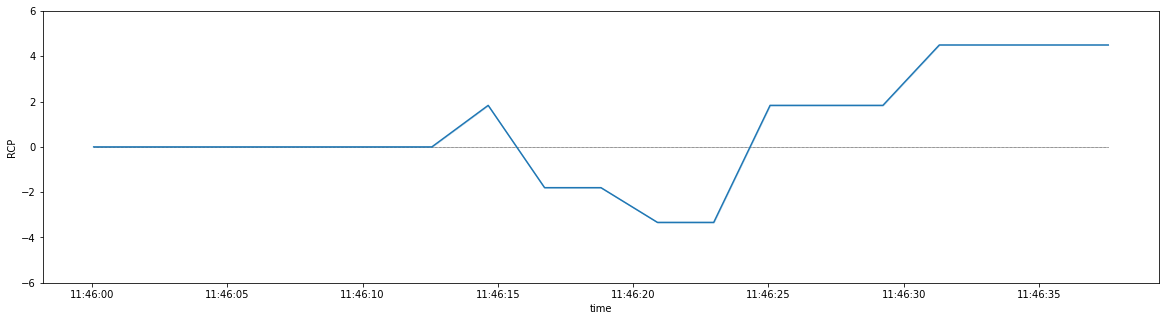

In [46]:
plt.figure(figsize=(20,5))
sns.lineplot(x='time', y=0, data=df_tf_trends.xs((1, 2, 'All Heroes'), level=['map_order', 'TF_order', 'hero_name']), color='black', linestyle=':', linewidth=0.5)
sns.lineplot(x='time', y='RCP', data=df_tf_trends.xs((1, 2, 'All Heroes'), level=['map_order', 'TF_order', 'hero_name']))
plt.ylim(-6,6)
plt.show()

In [47]:
# save to csv
df_trends = stat_report.get_trends()
df_trends.to_csv('results/stat/'+f'{match_id}_df_trends.csv')
df_tf_trends = stat_report.get_tf_trends()
df_tf_trends.to_csv('results/stat/'+f'{match_id}_df_tf_trends.csv')

# representative report summary for tableau visualization
stat_report.set_mode('teamfight')
stat_report.set_category('player')
report_summary = stat_report.get_report_summary()
print('teamfight-player report')
display(report_summary)
report_summary.to_csv('results/stat/'+f'{match_id}_report_summary.csv')

teamfight-player report


Time Played  \
map_order map_name      TF_order TF_winner          esports_team_id    battletag hero_name                 
1         Busan         1        Guangzhou Charge   Guangzhou Charge   Chara     All Heroes      33.0996   
                                                                                 Lúcio           33.0996   
                                                                       Cr0ng     All Heroes      33.0996   
                                                                                 Sigma           33.0996   
                                                                       Eileen    All Heroes      33.0996   
...                                                                                                  ...   
5         Lijiang Tower 13       New York Excelsior New York Excelsior Nenne     Tracer           0.0000   
                                                                       anamo     All Heroes      29.1940   
                                                                                 Brigitte         0.0000   
                                                                                 Lúcio            0.0000   
                                                                                 Mercy           29.1940   

                                                                                             Final Blows  \
map_order map_name      TF_order TF_winner          esports_team_id    battletag hero_name                 
1         Busan         1        Guangzhou Charge   Guangzhou Charge   Chara     All Heroes          2.0   
                                                                                 Lúcio               2.0   
                                                                       Cr0ng     All Heroes          0.0   
                                                                                 Sigma               0.0   
                                                                       Eileen    All Heroes          2.0   
...                                                                                                  ...   
5         Lijiang Tower 13       New York Excelsior New York Excelsior Nenne     Tracer              0.0   
                                                                       anamo     All Heroes          0.0   
                                                                                 Brigitte            0.0   
                                                                                 Lúcio               0.0   
                                                                                 Mercy               0.0   

                                                                                             Deaths  \
map_order map_name      TF_order TF_winner          esports_team_id    battletag hero_name            
1         Busan         1        Guangzhou Charge   Guangzhou Charge   Chara     All Heroes     0.0   
                                                                                 Lúcio          0.0   
                                                                       Cr0ng     All Heroes     0.0   
                                                                                 Sigma          0.0   
                                                                       Eileen    All Heroes     0.0   
...                                                                                             ...   
5         Lijiang Tower 13       New York Excelsior New York Excelsior Nenne     Tracer         0.0   
                                                                       anamo     All Heroes     0.0   
                                                                                 Brigitte       0.0   
                                                                                 Lúcio          0.0   
                                               

In [ ]:
# report summary
# match-player report
stat_report.set_mode('match')
stat_report.set_category('player')
report_summary = stat_report.get_report_summary()
print('match-player report')
display(report_summary)
# map-player report
stat_report.set_mode('map')
stat_report.set_category('player')
report_summary = stat_report.get_report_summary()
print('map-player report')
display(report_summary)
# teamfight-player report
stat_report.set_mode('teamfight')
stat_report.set_category('player')
report_summary = stat_report.get_report_summary()
print('teamfight-player report')
display(report_summary)
# match-team report
stat_report.set_mode('match')
stat_report.set_category('team')
report_summary = stat_report.get_report_summary()
print('match-team report')
display(report_summary)
# map-team report
stat_report.set_mode('map')
stat_report.set_category('team')
report_summary = stat_report.get_report_summary()
print('map-team report')
display(report_summary)
# teamfight-team report
stat_report.set_mode('teamfight')
stat_report.set_category('team')
report_summary = stat_report.get_report_summary()
print('teamfight-team report')
display(report_summary)

## Save esd_tf to MySQL DB

In [ ]:
# save esd_tf to mysql DB
def export_to_db(esd_tf, dbname="teamfight"):
    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    port = 3306
    # dbname = "teamfight" # schema name to export the df
    charset = "utf8"

    # Create engine
    engine = create_engine('mysql+pymysql://' + username + ':' + pwd + '@' + hostname + ':' + str(port) + '/' + dbname , echo=False)

    # export dataframe into mysql
    table_id = f'match_{match_id}'
    esd_tf.to_sql(name=table_id, con=engine, schema=dbname, if_exists='fail')


## Visualization